In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Scaffolds import MurckoScaffold

from matplotlib import pyplot
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

import csv

import numpy as np
import re

import pandas as pd
import seaborn as sns


In [2]:
# načtení inhibitorů COX-2 z ChEMBLu
with open("C:/cdd2024/chembl_cox2.csv", 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    chembl_cox2 = [Chem.MolFromSmiles(m['Smiles']) for m in reader]
    
# načtení schválených léčiv z ChEMBLu
with open("C:/cdd2024/drugs.csv", 'r') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    drugs = [Chem.MolFromSmiles(m['Smiles']) for m in reader]

[08:36:45] WARNING: not removing hydrogen atom without neighbors
[08:36:45] WARNING: not removing hydrogen atom without neighbors
[08:36:45] WARNING: not removing hydrogen atom without neighbors
[08:36:45] WARNING: not removing hydrogen atom without neighbors
[08:36:45] WARNING: not removing hydrogen atom without neighbors
[08:36:45] WARNING: not removing hydrogen atom without neighbors


In [3]:
# Výpočet fyz-chem deskriptorů pro COX-2 inhibitory
chembl_cox2_rings = [len(Chem.GetSSSR(l)) for l in chembl_cox2]
chembl_cox2_rotatable = [Chem.CalcNumRotatableBonds(l) for l in chembl_cox2]
chembl_cox2_atomcount = [l.GetNumHeavyAtoms() for l in chembl_cox2]
chembl_cox2_hba = [rdescriptors.CalcNumLipinskiHBA(l) for l in chembl_cox2]
chembl_cox2_hbd = [rdescriptors.CalcNumLipinskiHBD(l) for l in chembl_cox2]
chembl_cox2_molwt = [rdescriptors.CalcExactMolWt(l) for l in chembl_cox2]
chembl_cox2_tpsa = [rdescriptors.CalcTPSA(l) for l in chembl_cox2]
chembl_cox2_logp = [Descriptors.MolLogP(l) for l in chembl_cox2]

sns.set(rc={'figure.figsize':(11.7, 11.7)})

# Vytvoření dataframe
chembl_cox2_prop_df = pd.DataFrame(data={'set':'chembl_cox2', 'rings': chembl_cox2_rings,
                        'rotatable': chembl_cox2_rotatable, 'atoms': chembl_cox2_atomcount,
                        'hba': chembl_cox2_hba, 'hbd': chembl_cox2_hbd, 'molwt': chembl_cox2_molwt,
                        'tpsa': chembl_cox2_tpsa, 'logp': chembl_cox2_logp})

In [4]:
# Výpočet fyz-chem deskriptorů pro množinu léčiv
drugs_rings = [len(Chem.GetSSSR(l)) for l in drugs]
drugs_rotatable = [Chem.CalcNumRotatableBonds(l) for l in drugs]
drugs_atomcount = [l.GetNumHeavyAtoms() for l in drugs]
drugs_hba = [rdescriptors.CalcNumLipinskiHBA(l) for l in drugs]
drugs_hbd = [rdescriptors.CalcNumLipinskiHBD(l) for l in drugs]
drugs_molwt = [rdescriptors.CalcExactMolWt(l) for l in drugs]
drugs_tpsa = [rdescriptors.CalcTPSA(l) for l in drugs]
drugs_logp = [Descriptors.MolLogP(l) for l in drugs]

sns.set(rc={'figure.figsize':(11.7, 11.7)})
# Vytvoření dataframe
drugs_prop_df = pd.DataFrame(data={'set':'drugs', 'rings': drugs_rings,
                        'rotatable': drugs_rotatable, 'atoms': drugs_atomcount,
                        'hba': drugs_hba, 'hbd': drugs_hbd, 'molwt': drugs_molwt,
                        'tpsa': drugs_tpsa, 'logp': drugs_logp})

In [5]:
# Spojení dataframů
joint_prop_df = pd.concat([chembl_cox2_prop_df, drugs_prop_df], ignore_index=True)
melted_prop_df = pd.melt(joint_prop_df, id_vars=['set'], value_vars=['rings', 'rotatable', 'atoms', 'hba', 'hbd', 'logp'])
melted_prop_df2 = pd.melt(joint_prop_df, id_vars=['set'], value_vars=['molwt', 'tpsa'])

<Axes: xlabel='variable', ylabel='value'>

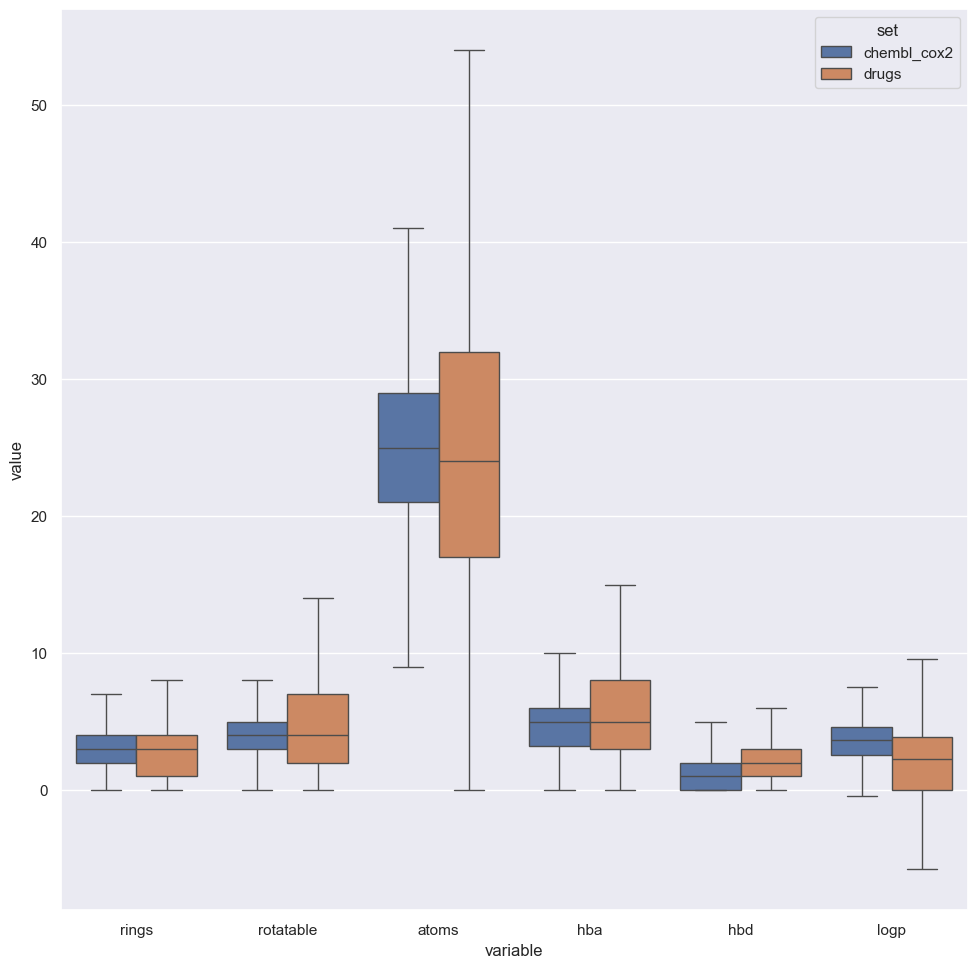

In [6]:
# Graf srovnání hodnot deskriptorů pro COX-2 inhibit. vs léčiva
sns.boxplot(y='value', x='variable', hue='set', data=melted_prop_df, showfliers=False)

<Axes: xlabel='variable', ylabel='value'>

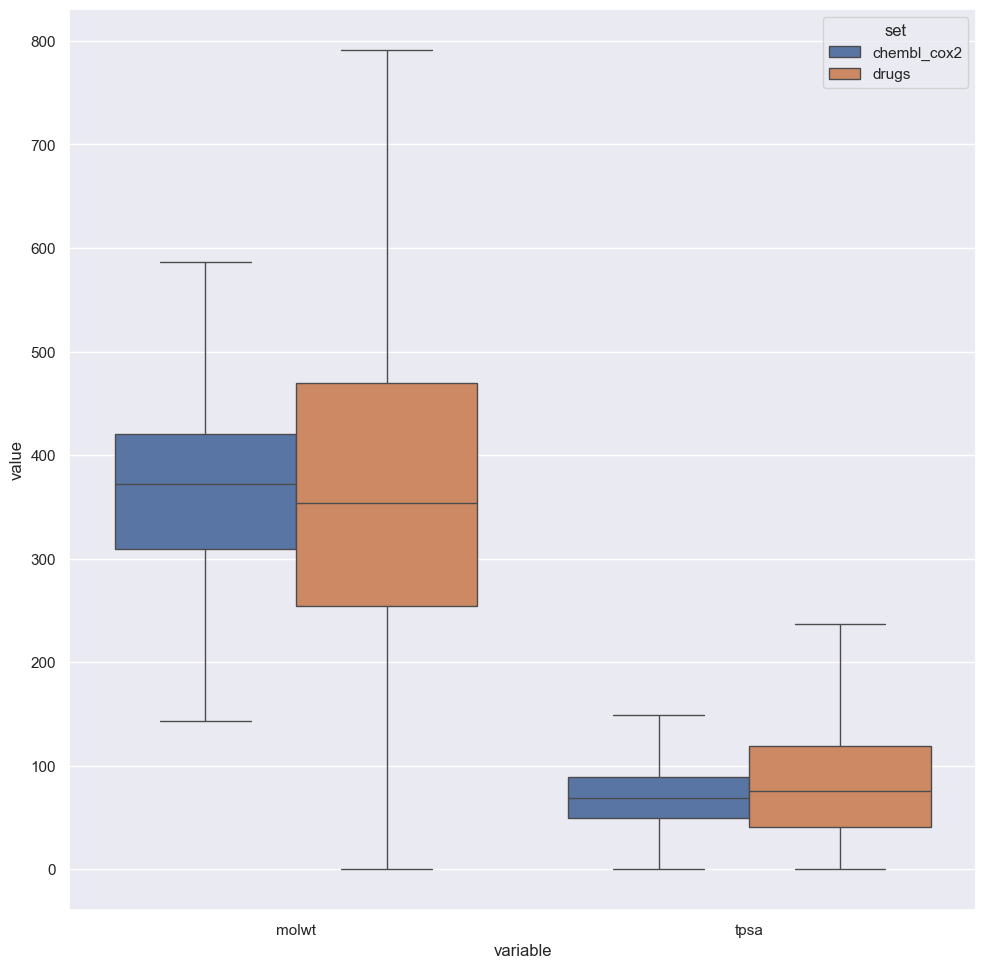

In [7]:
# Graf srovnání hodnot deskriptorů pro COX-2 inhibit. vs léčiva, řádově jiné hodnoty, proto zvláštní graf
sns.boxplot(y='value', x='variable', hue='set', data=melted_prop_df2, showfliers=False)

In [8]:
# Výpočet MACCS strukturních deskriptorů pro obě množiny
chembl_cox2_maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in chembl_cox2]
drugs_maccs = [MACCSkeys.GenMACCSKeys(mol) for mol in drugs]

In [9]:
# List 0 o dané délce
chembl_cox2_maccs_sums = [0]*chembl_cox2_maccs[0].GetNumBits()

# Sečtení aktivních bitů - získání frekvence výskytu MACCS motivu pro COX-2 inh.
for key in chembl_cox2_maccs:
    for onbit in key.GetOnBits():
        chembl_cox2_maccs_sums[onbit] += 1

# List 0 o dané délce
drugs_maccs_sums = [0]*drugs_maccs[0].GetNumBits() 

# Sečtení aktivních bitů - získání frekvence výskytu MACCS motivů pro množinu léčiv
for key in drugs_maccs:
    for onbit in key.GetOnBits():
        drugs_maccs_sums[onbit] += 1

In [10]:
# Normalizace dat 
chembl_cox2_maccs_scaled = [x/len(chembl_cox2_maccs) for x in chembl_cox2_maccs_sums]
drugs_maccs_scaled = [x/len(drugs_maccs) for x in drugs_maccs_sums]

# Vypočtení rozdílu frekvence výskytu MACCS motivů mezi COX-2 inh. a léčivy
drugs_cox2_maccs_differences = [(i, a_b[0] - a_b[1])
                             for i, a_b in enumerate(zip(drugs_maccs_scaled, chembl_cox2_maccs_scaled))]

# Seřazení rozdílu frekvence výskytu MACCS motivů
drugs_cox2_maccs_differences.sort(key=lambda x: x[1])

# Vypsání čtyř MACCS motivů s největší a čtyř s nejmenší frekvencí výskytu u léčiv v porovnání s COX-2 inhibitory
drugs_cox2_maccs_differences[:4], drugs_cox2_maccs_differences[-4:]

([(62, -0.3418273846035951),
  (64, -0.3395323838976799),
  (81, -0.336543894973643),
  (59, -0.33476478184462344)],
 [(153, 0.23667589591670407),
  (131, 0.24729154707245454),
  (100, 0.2882289263635638),
  (166, 0.3124085028766471)])

In [11]:
#Nejméně časté: 62 ('*@*!@*@*',0); 64 ('*@*!@[#16]',0); 81 ('[#16]~*(~*)~*',0) ; 59 ('[#16]!:*:*',0)
#Nejčastější: 153 ('[!#6;!#1]~[CH2]~*',0); 131 ('[!#6;!#1;!H0]',1); 100 ('*~[CH2]~[#7]',0); 166 ('?',0)

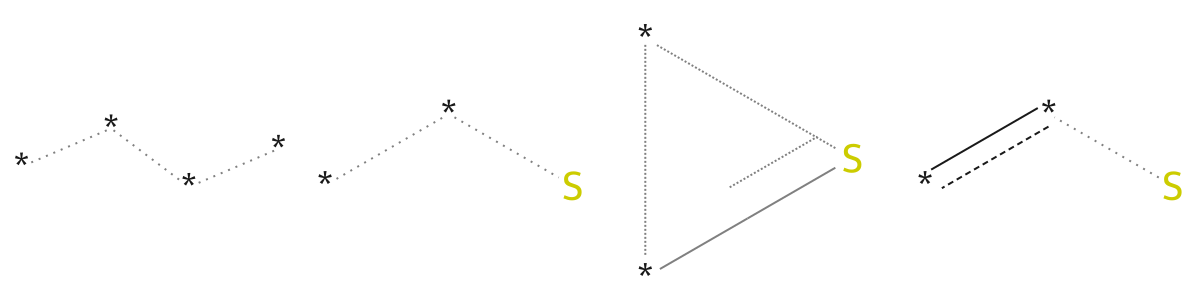

In [12]:
from PIL import Image
from IPython.display import display

# Seznam SMARTS řetězců
maccs_least = ["*@*!@*@*", "*@*!@[#16]", "[#16]1~*~*1", "[#16]!:*:*"]

# Vytvoření prázdného obrázku, na který budeme přidávat obrázky jednotlivých SMARTS řetězců
images = []

for smarts in maccs_least:
    # Převod SMARTS řetězce na obrázek
    mol = Chem.MolFromSmarts(smarts)
    if mol:
        # Přidání obrázku molekuly do seznamu obrázků
        img = Draw.MolToImage(mol, size=(300, 300))
        images.append(img)

# Horizontální spojení všech obrázků do jednoho
if images:
    result_image = Image.new('RGB', (len(images) * 300, 300))
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += 300

    # Zobrazení vytvořeného obrázku
    display(result_image)
else:
    print("Chyba")

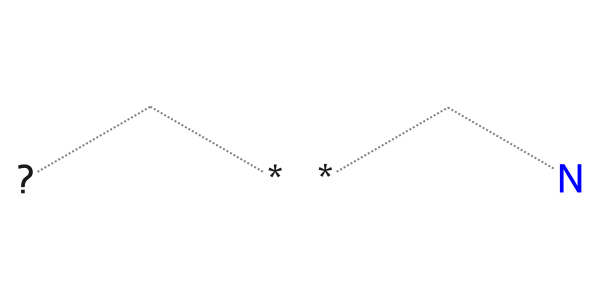

In [13]:
from PIL import Image
from IPython.display import display

# Seznam SMARTS řetězců
maccs_most = ["[!#6;!#1]~[CH2]~*", "*~[CH2]~[#7]",]

# Vytvoření prázdného obrázku, na který budeme přidávat obrázky jednotlivých SMARTS řetězců
images = []

for smarts in maccs_most:
    #  Převod SMARTS řetězce na obrázek
    mol = Chem.MolFromSmarts(smarts)
    if mol:
        # Přidání obrázku molekuly do seznamu obrázků
        img = Draw.MolToImage(mol, size=(300, 300))
        images.append(img)

# Horizontální spojení všech obrázků do jednoho
if images:
    result_image = Image.new('RGB', (len(images) * 300, 300))
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += 300

    # Zobrazení vytvořeného obrázku
    display(result_image)
else:
    print("Chyba")

In [14]:
chembl_cox2_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
                     for m in chembl_cox2]

drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in drugs]

[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerator
[08:36:58] DEPRECATION WARNING: please use MorganGenerat

In [15]:
# Analogicky pro ECFP
chembl_cox2_ecfp_sums = [0]*chembl_cox2_ecfp[0].GetNumBits()
for key in chembl_cox2_ecfp:
    for onbit in key.GetOnBits():
        chembl_cox2_ecfp_sums[onbit] += 1

In [16]:
drugs_ecfp_sums = [0]*drugs_ecfp[0].GetNumBits()
for key in drugs_ecfp:
    for onbit in key.GetOnBits():
        drugs_ecfp_sums[onbit] += 1

In [17]:
chembl_cox2_ecfp_scaled = [x/len(chembl_cox2_ecfp) for x in chembl_cox2_ecfp_sums]
drugs_ecfp_scaled = [x/len(drugs_ecfp) for x in drugs_ecfp_sums]

In [18]:
drugs_cox2_ecfp_differences = [(i, a_b[0] - a_b[1])
                             for i, a_b in enumerate(zip(drugs_ecfp_scaled, chembl_cox2_ecfp_scaled))]
drugs_cox2_ecfp_differences.sort(key=lambda x: x[1])
drugs_cox2_ecfp_differences[:3], drugs_cox2_ecfp_differences[-3:]

([(136, -0.34803253353787034),
  (319, -0.29931300136799094),
  (896, -0.28734868994932256)],
 [(807, 0.15361678786889232),
  (1019, 0.18148248381314275),
  (80, 0.21819386533901702)])

In [19]:
# Funkce pro odstranění stereochemie a získání scaffoldu pro molekulu
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) 
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) 
    except ValueError:
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) 
    return scaff

# Získání scaffoldů pro všechny molekuly v obou množinách
chembl_cox2_scaffolds = [scaffold(drug) for drug in chembl_cox2]
drugs_scaffolds = [scaffold(drug) for drug in drugs]

[08:36:59] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 7 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 9 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 6 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 7 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 5 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 4 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 7 C, 6, is greater than permitted
[08:37:00] Explicit valence for atom # 8 C, 6, is g

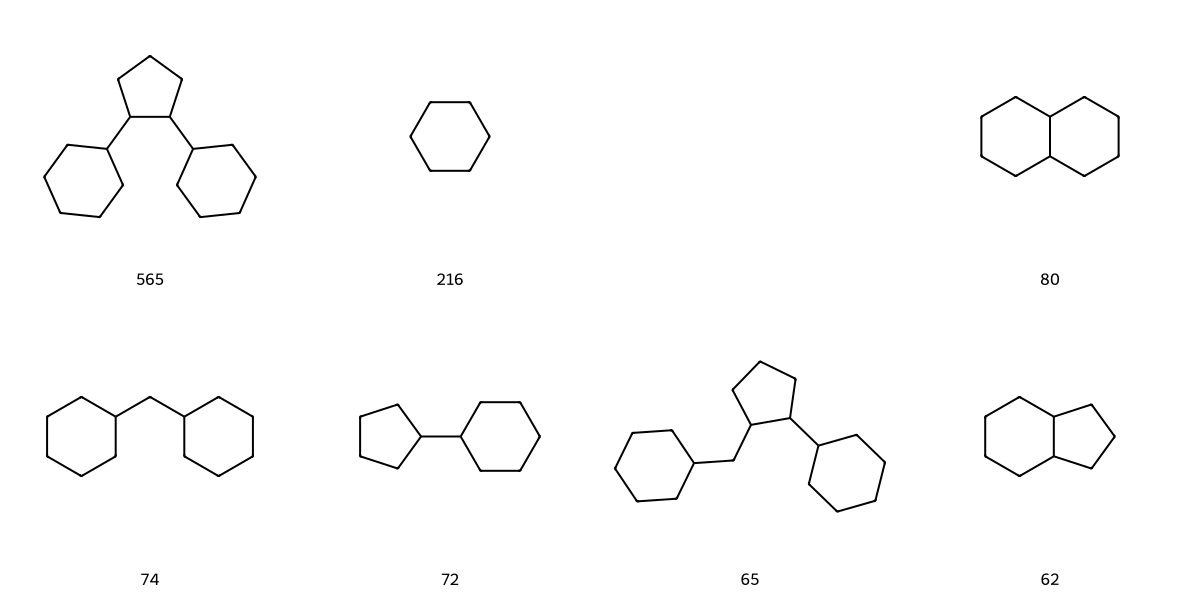

In [20]:
# Načítání scaffoldů jednolitvých molekul, seřazení scaffoldů dle jejich frekvence výskytu pro cox-2 množinu

chembl_cox2_scaffold_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(chembl_cox2_scaffolds) if mol]

chembl_cox2_scaffolds2drugs = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in chembl_cox2_scaffold_smiles}
for drug_idx, scaffoldsmiles in chembl_cox2_scaffold_smiles:
    chembl_cox2_scaffolds2drugs[scaffoldsmiles].append(drug_idx)

chembl_cox2_scaffold_drugcount = [(scaffold, len(drugs)) for scaffold, drugs in chembl_cox2_scaffolds2drugs.items()]
chembl_cox2_scaffold_drugcount.sort(key=lambda x: x[1], reverse=True)

# Vykreslení obrázků scaffoldů
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in chembl_cox2_scaffold_drugcount[:8]],
                     molsPerRow=4, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in chembl_cox2_scaffold_drugcount[:8]])

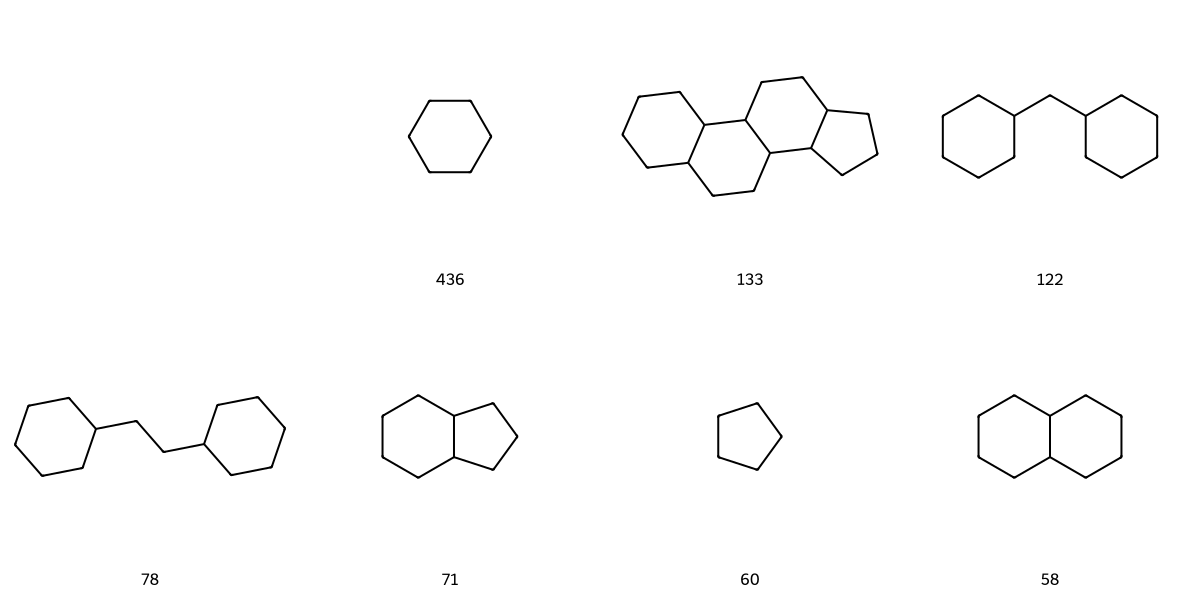

In [21]:
# Načítání scaffoldů jednolitvých molekul, seřazení scaffoldů dle jejich frekvence výskytu pro množinu léčiv

drugs_scaffolds_smiles = [(i, Chem.MolToSmiles(mol)) for i, mol in enumerate(drugs_scaffolds) if mol]

drugs_scaffolds2drugs = {scaffoldsmiles:[] for drug_idx, scaffoldsmiles in drugs_scaffolds_smiles}
for drug_idx, scaffoldsmiles in drugs_scaffolds_smiles:
    drugs_scaffolds2drugs[scaffoldsmiles].append(drug_idx)

drugs_scaffold_drugcount = [(scaffold, len(drugs)) for scaffold, drugs in drugs_scaffolds2drugs.items()]
drugs_scaffold_drugcount.sort(key=lambda x: x[1], reverse=True)

# Vykreslení obrázků scaffoldů
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold, count in drugs_scaffold_drugcount[:8]],
                     molsPerRow=4, subImgSize=(300,300),
                     legends=[str(count) for scaffold, count in drugs_scaffold_drugcount[:8]])

In [22]:
# Vytvoření prázdného listu pro ukládání dat z csv
mols = []

In [23]:
#pro převedení pChEMBL_value na float
float_pattern = re.compile("[0-9]+(/.[0-9]*)?")

In [24]:
# Načtení dat z datasetu COX-2 inhibitorů pro vizualizaci chemického prostoru

with open("C:/cdd2024/chembl_cox2.csv") as cox2:
    mols.extend([row for row in csv.DictReader(cox2, delimiter=";", quotechar='"')])
    for m in mols:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["smiles"] = m["Smiles"]
        m["source"] = "chembl_cox2"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024) # Vypočítání Forganova fpt 
        m["logp"] = Descriptors.MolLogP (m["rdmol"]) # Vypočtení hodnoty logP
        

[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerator
[08:37:03] DEPRECATION WARNING: please use MorganGenerat

In [25]:
# Načtení dat z datasetu léčiv pro vizualizaci chemického prostoru

with open("C:/cdd2024/drugs.csv", 'r') as drugs:
    reader = csv.reader(drugs, delimiter=";")
    header = next(reader)
    for row in reader:
        try:
            mol = Chem.MolFromSmiles(row[31])
        except Exception as e:
            print(row)
            raise e
        if mol:
            mols.append({
                 "source":"drugs",
                 "rdmol": mol,
                 "smiles": Chem.MolToSmiles(mol),
                 "pChEMBL_value": 0,
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024), # Vypočítání Forganova fpt 
                "logp" : Descriptors.MolLogP (mol), # Vypočtení hodnoty logP
                }
            )

[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerator
[08:37:06] DEPRECATION WARNING: please use MorganGenerat

In [26]:
dataframe = pd.DataFrame(mols, columns=["smiles","source", "rdmol", "fps", "pChEMBL_value", "logp"]) # Vytvoření dataframe

In [27]:
dataframe.reset_index(level=0, inplace=True)

In [28]:
dataframe = dataframe.join(pd.DataFrame((rdescriptors.MQNs_(mol) for mol in dataframe["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]) #Přidání sloupců do dataframe pro jednotlivá MQN a jejich výpočet
            )

In [29]:
# PCA analýza se všemi 42 MQN deskriptory
pca = decomposition.PCA(n_components=42)
pca.fit(dataframe[(f"MQN_{x}" for x in range(1, 43))])

dataframe = dataframe.join(pd.DataFrame(pca.transform(dataframe[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

In [30]:
# Normalizace hodnot MQN deskriptorů
norm = preprocessing.normalize(dataframe[(f"MQN_{x}" for x in range(1, 43))])

# PCA analýza s normovanými MQN deskriptory
pca.fit(norm)
dataframe = dataframe.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

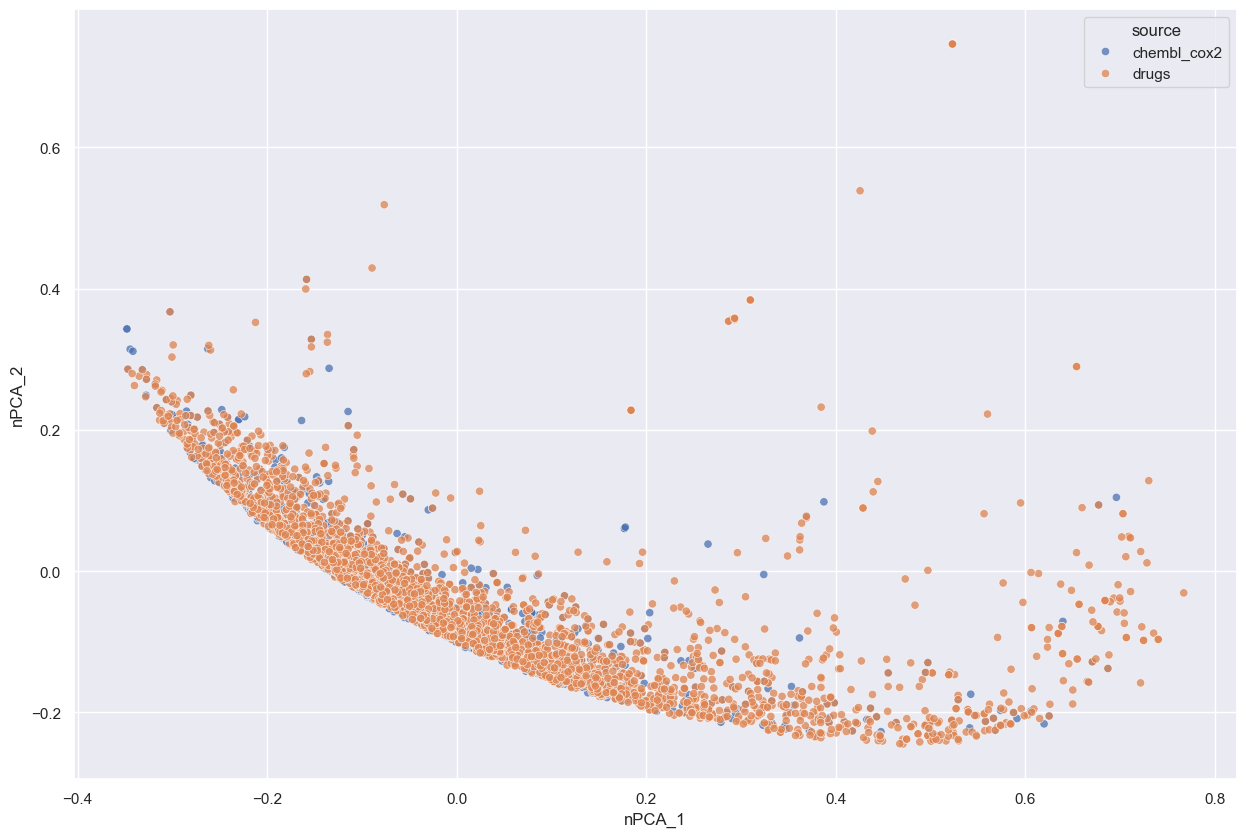

In [31]:
# Vizualizace výsledného chemického prostoru pomocí scatterplotu
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=dataframe,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

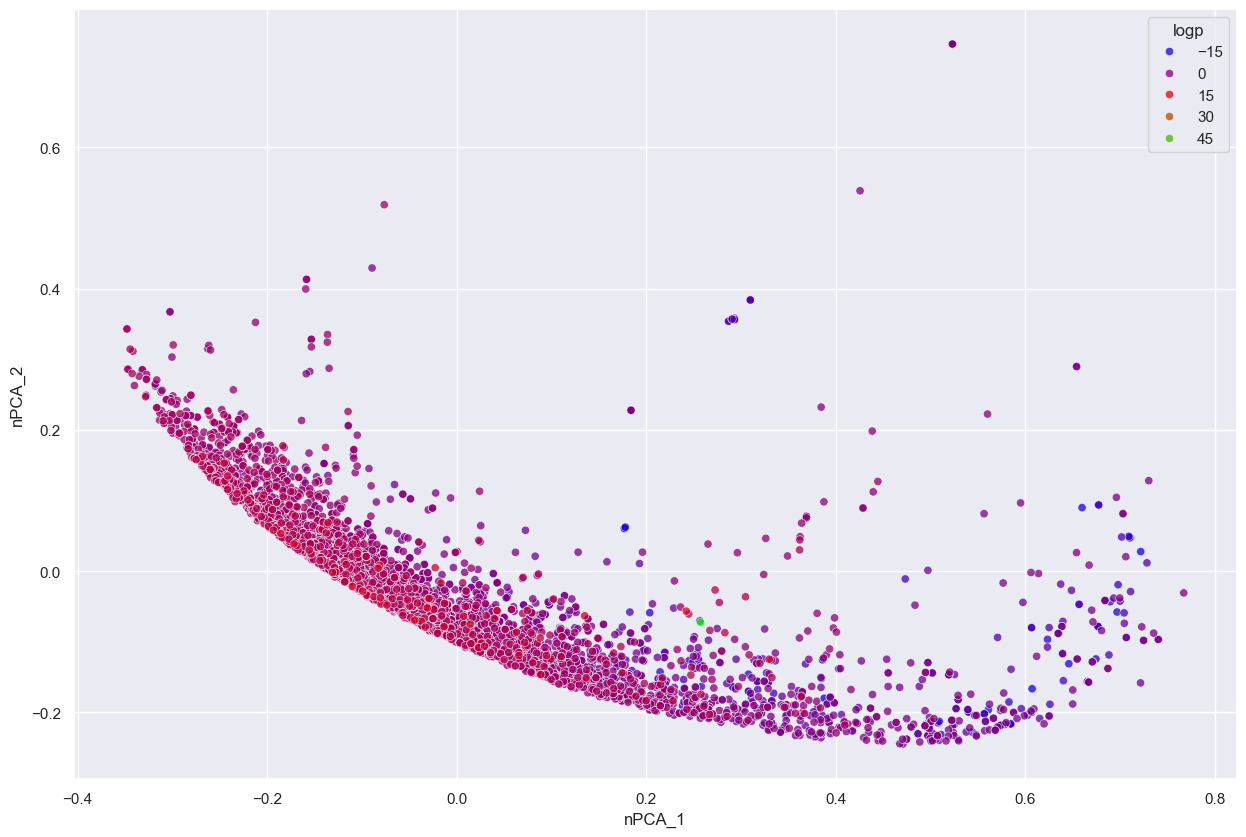

In [32]:
# Vizualizace pomocí scatterplotu, promítnutí hodnoty logp
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=dataframe.sort_values("logp"),
                      hue="logp",
                      palette ='brg',
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

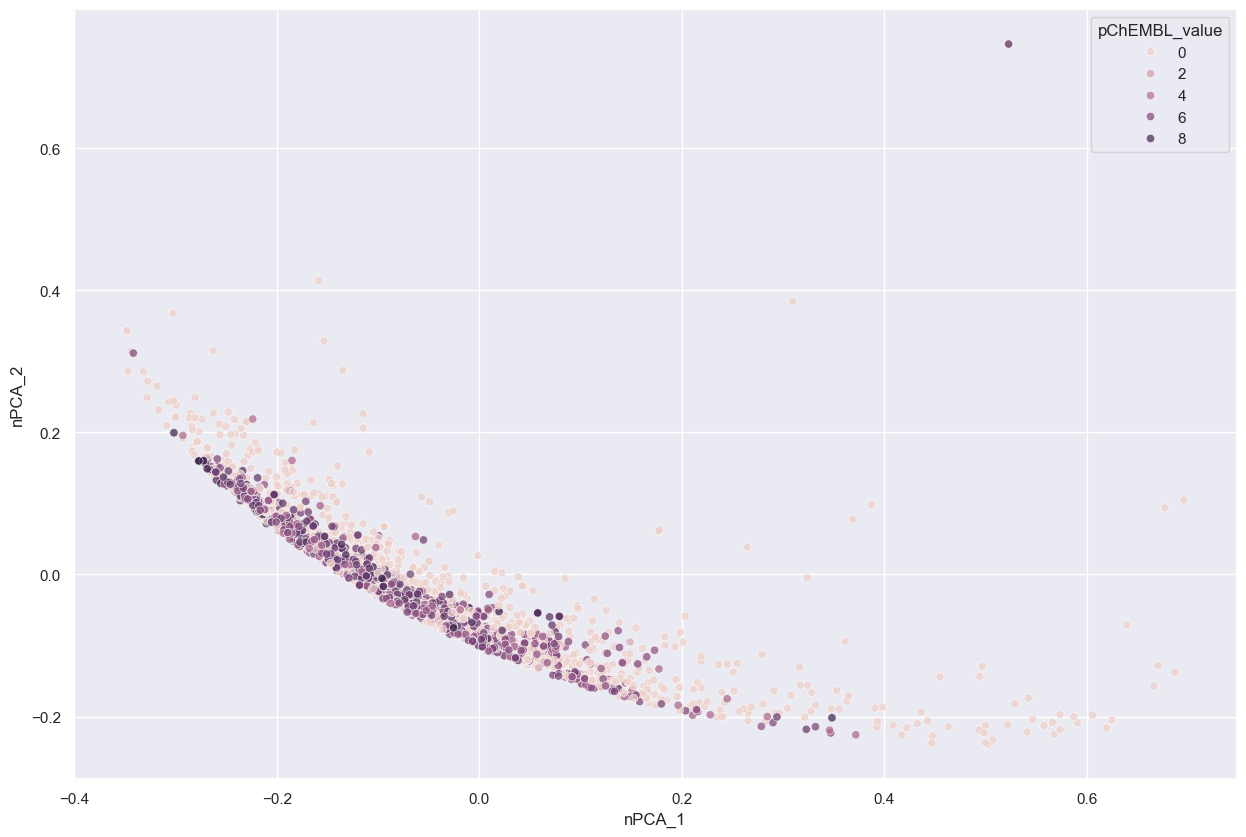

In [33]:
# Vizualizace pomocí scatterplotu, promytnutí hodnoty pChEMBL value; vynechání struktur z množiny léčiv - nemají uvedenou pChEMBL value
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=dataframe[dataframe.source == "chembl_cox2"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [34]:
# Výpočet vzdálenostní matice na základě Morganových fingerprintů mírou Jaccardova koeficientu
sparse_mat = distance.pdist(list(dataframe["fps"]),metric="jaccard")
# Převedení vzdálenostní matice na formát vhodný pro t-SNE analýzu
dist_mat = distance.squareform(sparse_mat)

In [35]:
# Provedení t-SNE analýzy

clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(dist_mat)

In [36]:
# Připojení sloupců hodnot získaných z provedené t-SNE analýzy do dataframe
dataframe = dataframe.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

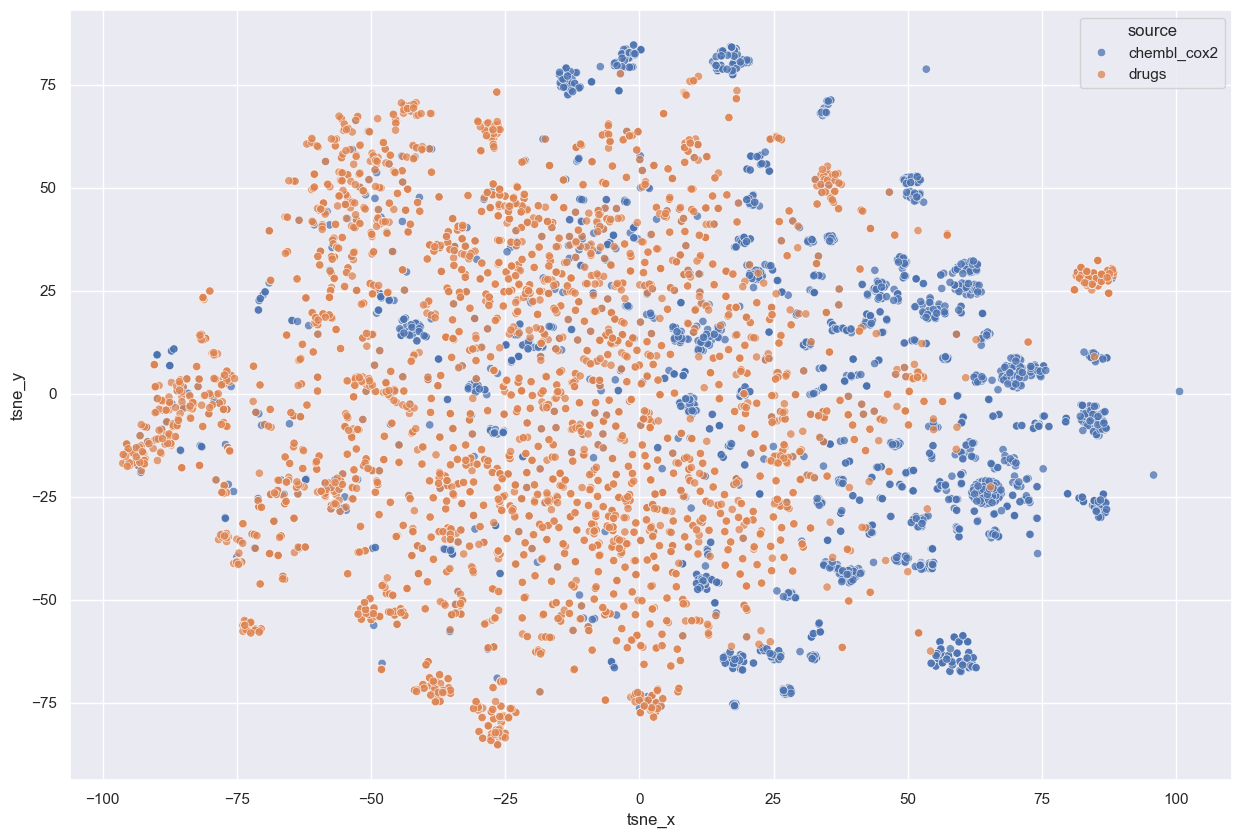

In [37]:
# Vizualizace výsledného chemického prostoru pomocí scatterplotu
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=dataframe,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

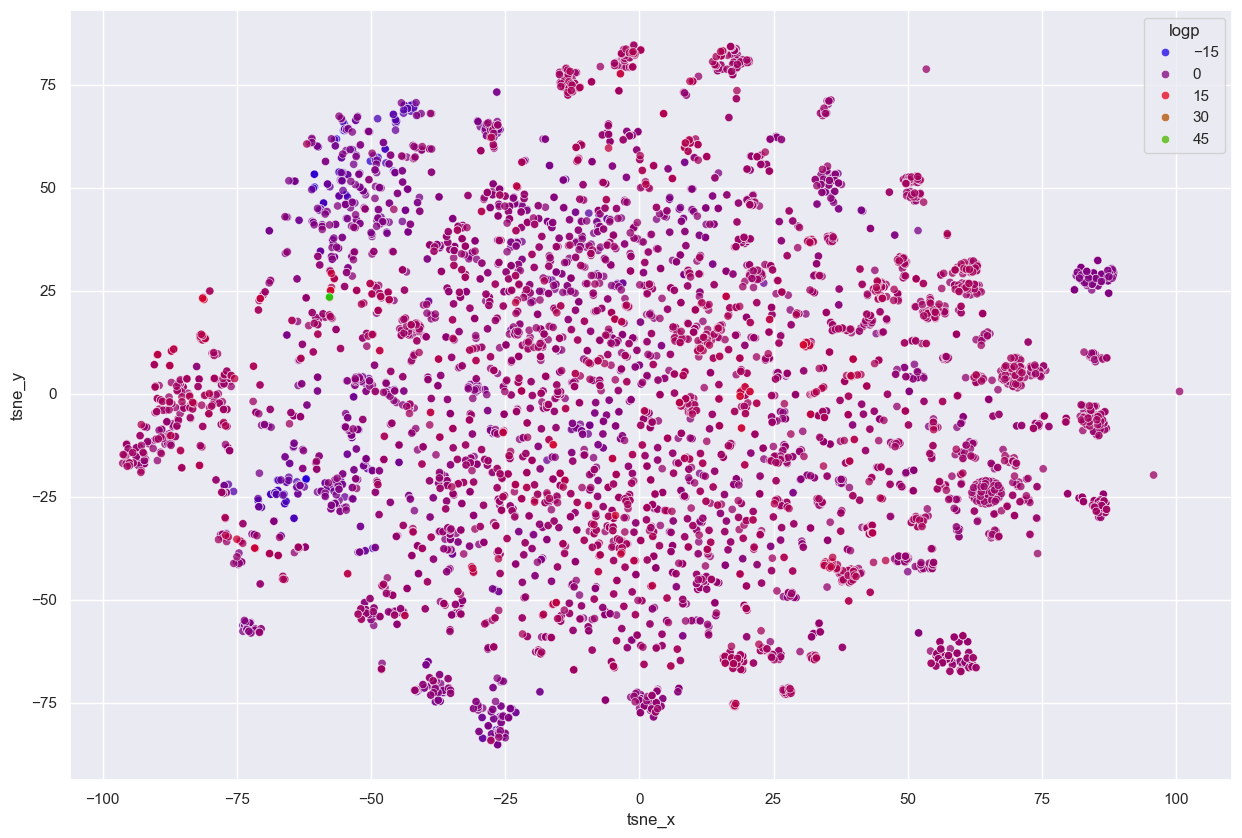

In [38]:
# Vizualizace výsledného chemického prostoru s promítnutím hodnot logp
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=dataframe.sort_values("logp"),
                      hue="logp",
                      palette ='brg',
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

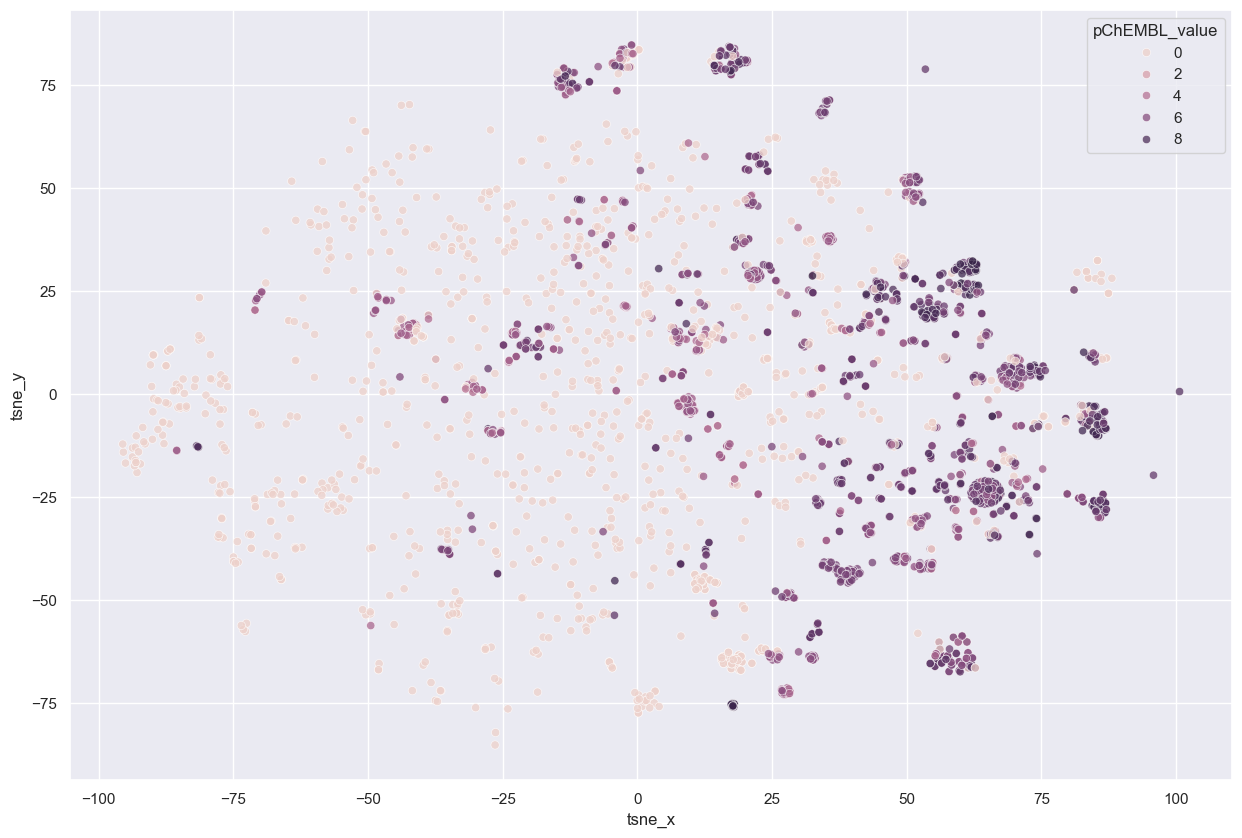

In [39]:
# Vizualizace výsledného chemického prostoru s promítnutím hodnot pChEMBL, data z množiny léčiv vynechána - nemají pChEMBL value
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=dataframe[dataframe.source == "chembl_cox2"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [40]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [41]:
# Definice funkce pro analýzu výsledků modelování

def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error whole set: {(res["Prediction"]-res[predicted_value]).abs().mean()}
Average error chembl_cox2: {(res[res["Source"]=="chembl_cox2"]["Prediction"]-res[res["Source"]=="chembl_cox2"][predicted_value]).abs().mean()}""")
    return res

In [42]:
# Rozdělení výchozí množiny inhibit. COX-2 na sadu trénovací a testovací
trainset, testset = ms.train_test_split(dataframe[dataframe["pChEMBL_value"]>0])
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [43]:
# Aplikace regresního modelu Support Vector Regression, učení na trénovací množině
model_svr = SVR()
model_svr.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL_value"])

SVR()

In [44]:
# Uložení výsledků za použití funkce get_results
train_results = get_results(model_svr, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")
test_results = get_results(model_svr, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 0.7819224830570293
Average error chembl_cox2: 0.7819224830570293
Average error whole set: 0.769996202986197
Average error chembl_cox2: 0.769996202986197


In [45]:
# Vyhodnocení přesnosti modelu
print("R^2: %0.2f" % model_svr.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(model_svr.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL_value"]))

R^2: 0.20
R: 0.44
MSE: 0.93


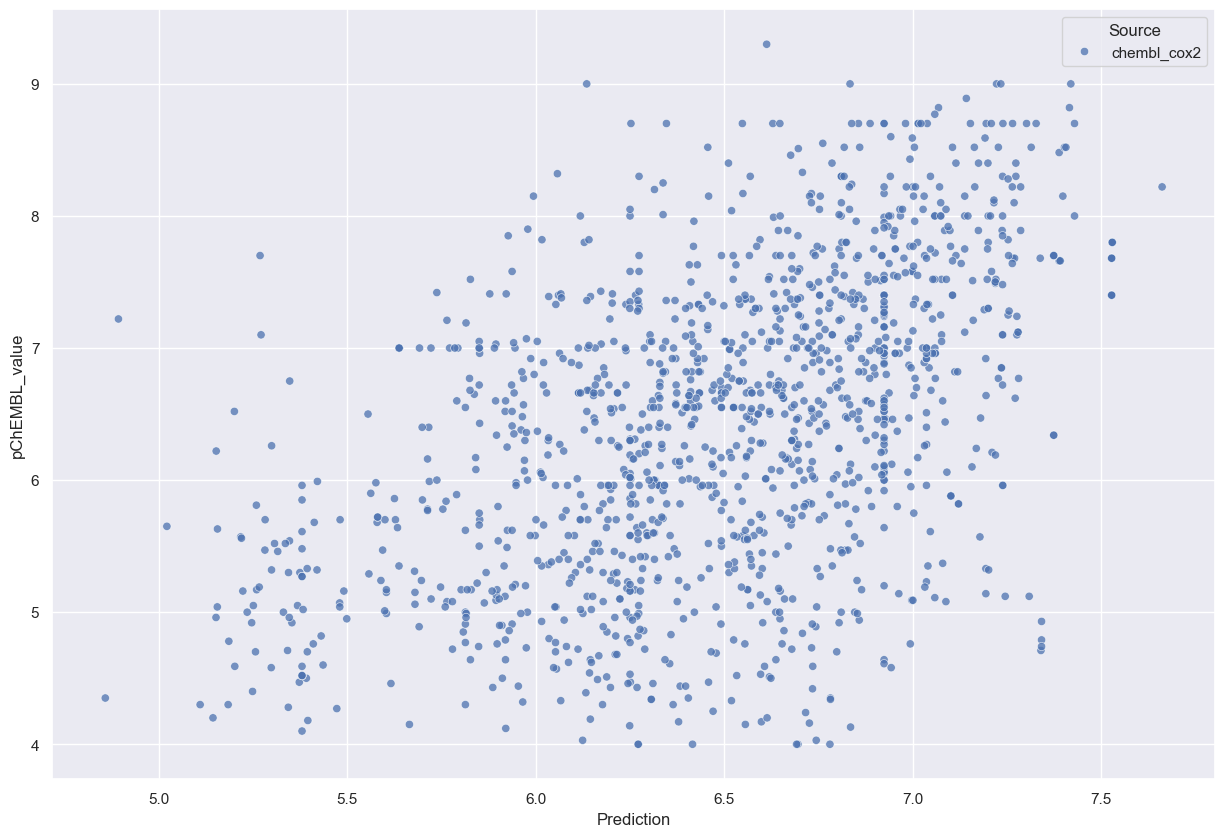

In [46]:
# Vykreslení scatterplotu Predikce vs. Skutečná hodnota na trénovací sadě
fig, ax = pyplot.subplots(figsize=(15,10))
p = sns.scatterplot(x="Prediction", 
                    y="pChEMBL_value", 
                    data=train_results, 
                    hue="Source", 
                    legend="brief", 
                    ax=ax, 
                    alpha=0.75)

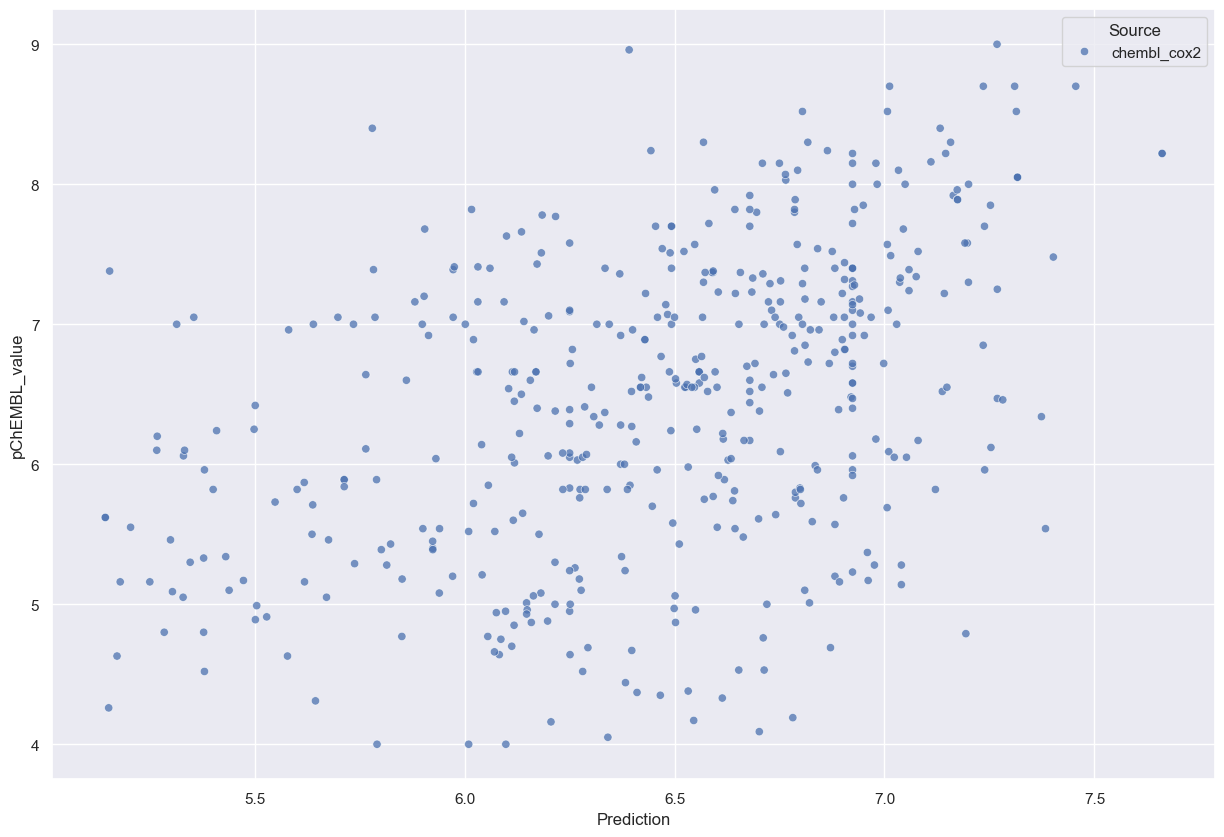

In [47]:
# Vykreslení scatterplotu Predikce vs. Skutečná hodnota na testovací sadě
fig, ax = pyplot.subplots(figsize=(15,10))
p = sns.scatterplot(x="Prediction", 
                    y="pChEMBL_value", 
                    data=test_results, 
                    hue="Source", 
                    legend="brief", 
                    ax=ax, 
                    alpha=0.75)

In [48]:
# Aplikace regresního modelu Random Forest, učení na trénovací množině
model_rf = ensemble.RandomForestRegressor()
model_rf.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL_value"])

RandomForestRegressor()

In [49]:
# Uložení výsledků za použití funkce get_results
train_results = get_results(model_rf, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")
test_results = get_results(model_rf, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL_value")

Average error whole set: 0.30982837356433746
Average error chembl_cox2: 0.30982837356433746
Average error whole set: 0.5574431813267832
Average error chembl_cox2: 0.5574431813267832


In [50]:
# Vypsání výsledků hodnocení přesnosti modelu
print("R^2: %0.2f" % model_rf.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"]))
print("R: %0.2f" % np.sqrt(model_rf.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL_value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL_value"]))

R^2: 0.49
R: 0.70
MSE: 0.59


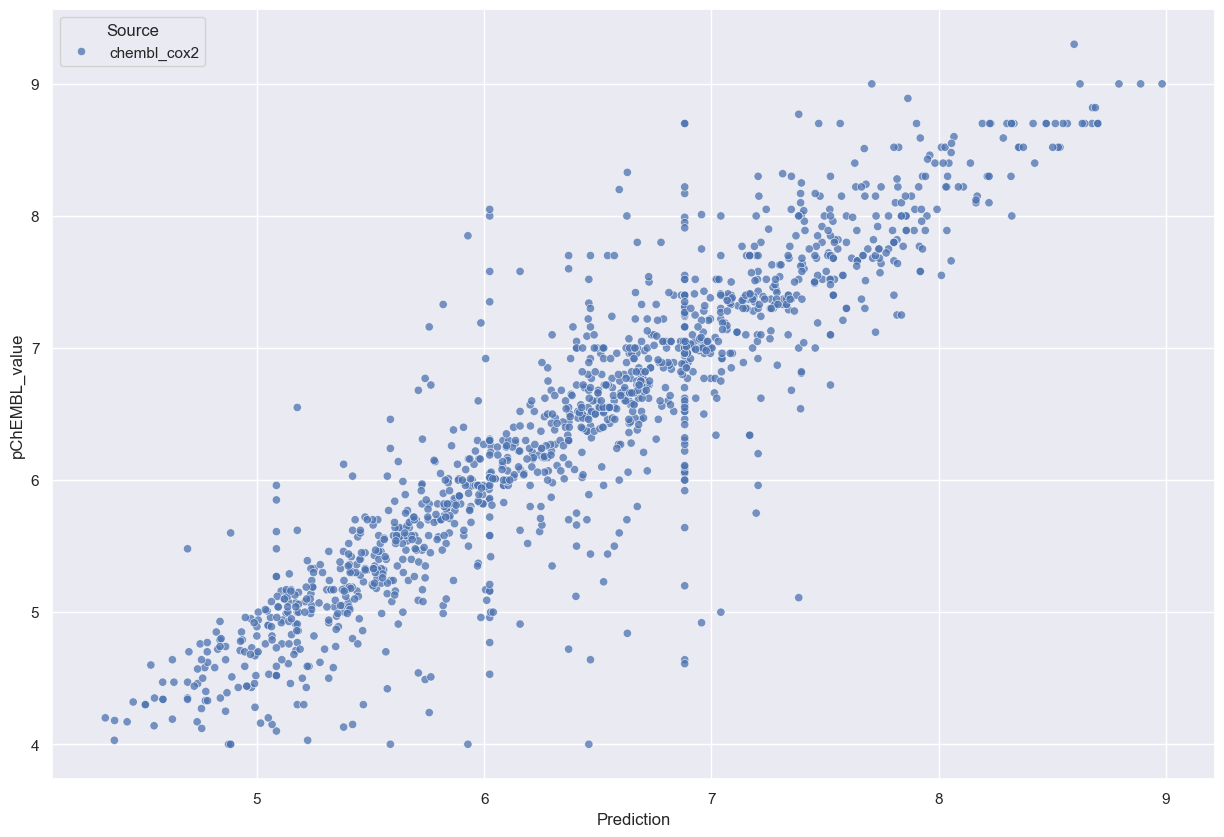

In [51]:
# Vykreslení scatterplotu Predikce vs. Skutečná hodnota na trénovací sadě
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="Prediction",
                      y="pChEMBL_value",
                      data=train_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

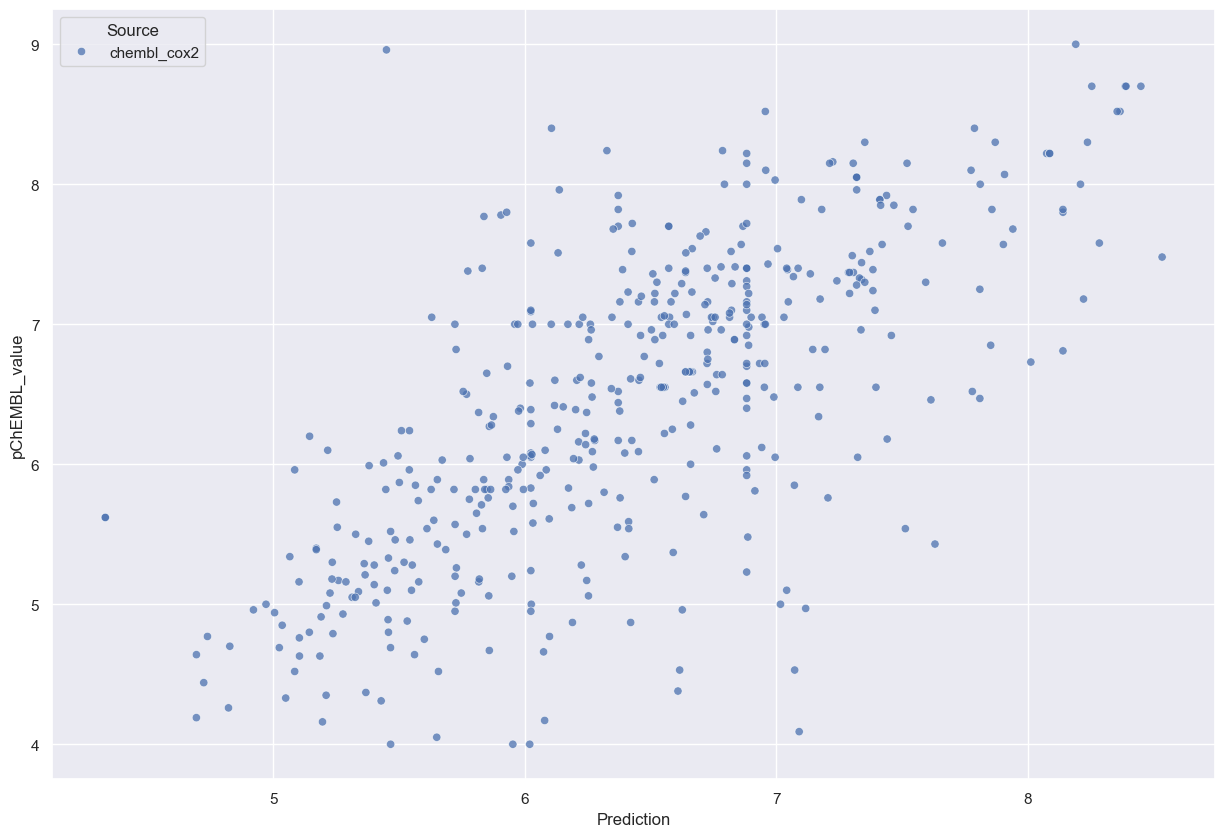

In [52]:
# Vykreslení scatterplotu Predikce vs. Skutečná hodnota na testovací sadě
fig, ax = pyplot.subplots(figsize=(15,10))
p=sns.scatterplot(x="Prediction",
                      y="pChEMBL_value",
                      data=test_results,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )